In [1]:
import os
import sys
sys.path.append(os.getcwd())
sys.path.insert(0, "../zeolite-property-prediction/code/")
sys.path.insert(0, "../zeolite-property-prediction/")


import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

import matplotlib.pyplot as plt
import matplotlib.ticker as tick

from tqdm import tqdm


from models.equivariant_mpnn import MPNNPORE
from utils.ZeoliteData import get_zeolite, get_data_pore, get_data_graph, get_data_megnet
from utils.dataloading import get_data, get_graph_data

In [2]:
import matplotlib as mpl

In [3]:
plt.rc('font', family='serif',)

In [4]:
from matplotlib import rc

In [5]:
data = get_zeolite('MFI', True)
    
ref = data['ref'] # reflections
tra = data['tra'] # translations
l = data['l'] # scale of the unit cell

# specific for MOR
atoms, hoa, X, A, d, X_pore, A_pore, d_pore, pore = get_data(l, 'MFI')

edges, idx1, idx2, idx2_oh = get_graph_data(A, d)
edges_sp, idx1_sp, idx2_sp, idx2_oh_sp = get_graph_data(A_pore, d_pore)
edges_ps, idx1_ps, idx2_ps, idx2_oh_ps = get_graph_data(A_pore.T, d_pore.T)

In [6]:
lim=22

In [7]:
_, testloader, trainloader = get_data_pore(atoms, hoa, edges, pore, edges_sp, edges_ps, bs=32, random=True)

In [8]:
trainX = trainloader.dataset.X.sum((1,2))[:,None].numpy()
trainy = trainloader.dataset.y[:,None].numpy()
testX = testloader.dataset.X.sum((1,2))[:,None].numpy()
testy = testloader.dataset.y[:,None].numpy()

In [9]:
from sklearn.linear_model import LinearRegression as LR

In [10]:
lr = LR()
lr.fit(trainX, trainy)

LinearRegression()

In [11]:
yhat = lr.predict(testX)

In [12]:
lr_mse, lr_mae = np.mean((testy - yhat)**2), np.mean(np.abs(testy - yhat))

In [13]:
atoms.shape[0]

3296

In [14]:
title_size=7.5
label_size=7

In [15]:
hoa.min(), hoa.max()

(26.0163, 81.3185)

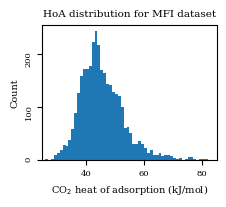

In [16]:
plt.figure(figsize=(2.25,1.75))
plt.hist(hoa, bins=np.arange(25,85,1))
plt.xlabel('CO$_2$ heat of adsorption (kJ/mol)', fontsize=label_size)
plt.ylabel('Count', fontsize=label_size)
plt.xticks(fontsize=6)
plt.yticks(fontsize=6, rotation='vertical')
plt.title('HoA distribution for MFI dataset', fontsize=title_size)
plt.xlim(25,85)
plt.savefig('figures/datadist_mfi.pdf', dpi=1200, bbox_inches="tight")
tikzz = plt.xticks()[0]

In [17]:
hoa_x = np.tile(np.linspace(25,85,60)[:,None], (1,13))
hoa_y = np.tile(np.arange(0,13,1)[None], (hoa_x.shape[0],1))

In [18]:
zi = np.zeros((len(hoa_x),13))

for i in range(len(atoms)):
    
    curr_h = hoa[i]
    
    n_als = atoms[i].sum()
              
    for _x in range(0,len(hoa_x)-1):
        
        if hoa_x[_x, n_als//2] < curr_h <= hoa_x[_x+1, n_als//2]:
            zi[_x, n_als//2] += 1

In [19]:
zi.sum(0)

array([ 21.,  70., 320., 320., 320., 320., 320., 320., 290., 320., 320.,
       200., 155.])

In [20]:
zi = zi/zi.sum(0)[None]

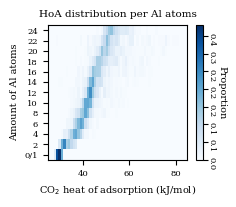

In [21]:
fig, ax = plt.subplots(figsize=(2.25,1.75))
CS = plt.pcolormesh(hoa_x, hoa_y, zi,
                  vmax=zi.max(), vmin=0, cmap='Blues')
#plt.colorbar()
plt.xlabel(f"CO$_2$ heat of adsorption (kJ/mol)", fontsize=label_size)
plt.ylabel(f"Amount of Al atoms", fontsize=label_size)
plt.title("HoA distribution per Al atoms", fontsize=title_size)
cbar = plt.colorbar()
plt.yticks(np.arange(0.,13, 1), ['0/1'] + np.arange(2,26,2).tolist(), fontsize=6, rotation='horizontal')
plt.xticks(tikzz)
plt.xticks(fontsize=6)
plt.xlim(25,85)
plt.ylim(-0.5,12.5)
cbar.ax.tick_params(labelsize=6, rotation=270,pad=0)
cbar.ax.get_yaxis().labelpad = 8
cbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.1f'))
cbar.set_label('Proportion', rotation=270, fontsize=label_size)
plt.savefig('figures/aldist_mfi.pdf', dpi=1200, bbox_inches="tight")

In [22]:
hoa_x.shape, hoa_y.shape, zi.shape

((60, 13), (60, 13), (60, 13))

In [23]:
mpnn = MPNNPORE(idx1.to('cuda'), idx2.to('cuda'), idx2_oh.to('cuda'), X, X_pore, ref, tra,
                    idx1_sp.to('cuda'), idx2_sp.to('cuda'), idx2_oh_sp.to('cuda'), 
                    idx1_ps.to('cuda'), idx2_ps.to('cuda'), idx2_oh_ps.to('cuda'),
                    hid_size=[8]*6, site_emb_size=8, edge_emb_size=8, mlp_size=24,
                    centers=10, mx_d=6, width=1, pool='sum', pool_pore=True).to('cuda')

mpnn2 = MPNNPORE(idx1.to('cuda'), idx2.to('cuda'), idx2_oh.to('cuda'), X, X_pore, ref, tra,
                    idx1_sp.to('cuda'), idx2_sp.to('cuda'), idx2_oh_sp.to('cuda'), 
                    idx1_ps.to('cuda'), idx2_ps.to('cuda'), idx2_oh_ps.to('cuda'),
                    hid_size=[8]*6, site_emb_size=8, edge_emb_size=8, mlp_size=24,
                    centers=10, mx_d=6, width=1, pool='sum', pool_pore=True, site_pred=True).to('cuda')

In [24]:
def get_95_CI(x):
    
    ci = 1.96*np.std(x)/np.sqrt(len(x))
    return ci

In [25]:
_mae_p = []
_mse_p = []

_mae_p2 = []
_mse_p2 = []


for j in tqdm(range(1,11)):

    mpnn.load_state_dict(torch.load(f'model_data_random/MFI/1.0/pore/model_{j}/model.pth'))
    y_pred, y_true = mpnn.predict(testloader)

    _mse = ((y_pred - y_true)**2).mean().item()
    _mae = (y_pred - y_true).abs().mean().item()

    _mae_p.append(_mae)
    _mse_p.append(_mse)

    mpnn2.load_state_dict(torch.load(f'model_data_random2/MFI/1.0/pore/model_{j}/model.pth'))
    y_pred, y_true = mpnn2.predict(testloader)

    _mse = ((y_pred - y_true)**2).mean().item()
    _mae = (y_pred - y_true).abs().mean().item()

    _mae_p2.append(_mae)
    _mse_p2.append(_mse)



mae_p  = np.mean(_mae_p)
mse_p = np.mean(_mse_p)
mae_p2  = np.mean(_mae_p2)
mse_p2 = np.mean(_mse_p2)


mae_p_ci = get_95_CI(_mae_p)
mse_p_ci = get_95_CI(_mse_p)
mae_p2_ci = get_95_CI(_mae_p2)
mse_p2_ci = get_95_CI(_mse_p2)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:42<00:00, 10.23s/it]


In [26]:
mae_p, mae_p2, mse_p, mse_p2

(5.0666348695755, 4.166585683822632, 35.345751190185545, 25.67901954650879)

In [27]:
best_idx = np.argmin(_mae_p)
mpnn.load_state_dict(torch.load(f'model_data_random/MFI/1.0/pore/model_{best_idx+1}/model.pth'))
y_pred, y_true = mpnn.predict(testloader)

In [28]:
from scipy.interpolate import griddata

In [29]:
y_pred.min(), y_pred.max(), y_true.min(), y_true.max()

(tensor(26.8236), tensor(72.3058), tensor(29.4428), tensor(77.3927))

In [30]:
Z = torch.ones_like(y_pred)

In [31]:
nn = 60
xmin = 25
xmax = 80
xi = np.linspace(xmin, xmax, nn)
yi = np.linspace(xmin, xmax, nn)

In [32]:
zi = np.zeros((nn,nn))

for i in range(len(y_pred)):
    
    curr_p = y_pred[i].item()
    curr_t = y_true[i].item()
    
    for _x in range(0,nn-1):
        
        if xi[_x] < curr_p <= xi[_x+1]:
            
            for _y in range(0,nn-1):
                
                if yi[_y] < curr_t <= xi[_y+1]:
                    
                    zi[_x,_y] += 1

In [33]:
len(np.unique(zi)), np.unique(zi), zi.max()

(8, array([0., 1., 2., 3., 4., 5., 6., 8.]), 8.0)

In [34]:
n_colors = int(zi.max())

C:\Users\20175552\AppData\Local\Temp\ipykernel_24540\522922956.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Blues', n_colors+1)


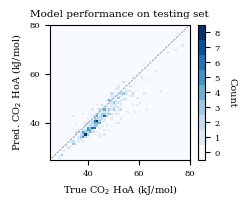

In [35]:
fig, ax = plt.subplots(figsize=(2.25,1.75))
cmap = plt.cm.get_cmap('Blues', n_colors+1)
CS = plt.pcolormesh(xi, yi, zi,
                  vmax=zi.max(), vmin=0, cmap=cmap)
plt.xlabel(f"True CO$_2$ HoA (kJ/mol)", fontsize=label_size)
plt.ylabel(f"Pred. CO$_2$ HoA (kJ/mol)", fontsize=label_size)
plt.title("Model performance on testing set", fontsize=title_size)
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".5", lw=.5)
cbar = plt.colorbar()
cbar.ax.get_yaxis().labelpad = 12
cbar.set_label('Count', rotation=270, fontsize=label_size)
cbar.ax.get_yaxis().set_ticks(np.arange((n_colors)/(2*(n_colors+1)), n_colors, (n_colors)/(n_colors+1)), np.arange(n_colors+1) )
cbar.ax.tick_params(labelsize=6)
plt.xticks(plt.yticks()[0])
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
plt.xlim(xmin,xmax)
plt.ylim(xmin,xmax)

plt.savefig('figures/truepred_mfi_int.pdf', dpi=1200, bbox_inches="tight")

In [36]:
_X = X[X[:,1]>0.75]

color = np.zeros((_X.shape[0],))
for i in range(len(_X)):

    yy = False
    for j in range(12):
        
        for k in range(ref.shape[0]):
            
            if np.abs(_X[i] - (np.mod(ref[k]*X[j] + tra[k], 1))).sum() < 0.01:
            # if (X[i] == (np.mod(ref[k]*X[j] + tra[k], 1))).all():
                
                color[i] = j
                yy = True  
                break

    if yy is not True:
        color[i] = -1

print(color)

[ 6.  7.  8.  9. 10. 11.  0.  1.  2.  3.  4.  5.  0.  1.  2.  3.  4.  5.
  6.  7.  8.  9. 10. 11.]


In [37]:
color2 = np.zeros((X_pore.shape[0]-2,))
for i in range(len(X_pore)-2):
    
    for j in range(len(X_pore)-2):
        
        for k in range(ref.shape[0]):

            if np.abs(X_pore[i] - (np.mod(ref[k]*X_pore[j] + tra[k], 1))).sum() < 0.001:
                
                color2[i] = j
                
                break
        

In [38]:
_A = A[X[:,1]>0.75]
_A = _A[:,X[:,1]>0.75]

In [39]:
_A.shape

(24, 24)

In [40]:
ce_dict = {}
row, col = np.nonzero(_A)
n_c = 0
for i in range(len(row)):
    
    added = False
    
    r,c = row[i], col[i]
    
    for j in ce_dict:
        
        if added: break
        
        test = ce_dict[j][0]
        
        test_r = _X[test[0]]
        test_c = _X[test[1]]
        
        
        for k in range(ref.shape[0]):
            
            r1 = np.mod(ref[k]*_X[r] + tra[k], 1)
            r2 = np.mod(ref[k]*_X[c] + tra[k], 1)
            
            if np.abs(r1-test_r).sum() < 0.001 and np.abs(r2-test_c).sum() < 0.001:
                
                ce_dict[j].append((r,c))
                
                added = True
                break
        
    if not added:
        ce_dict[n_c] = [(r,c)]
        n_c += 1

In [41]:
_A_pore = A_pore[X[:,1]>0.75]

In [42]:
cp_dict = {}
row, col = np.nonzero(_A_pore[:,:12])
n_c = 0
for i in range(len(row)):
    
    added = False
    
    r,c = row[i], col[i]
    
    for j in cp_dict:
        
        if added: break
        
        test = cp_dict[j][0]
        
        test_r = _X[test[0]]
        test_c = X_pore[test[1]]
        
        
        for k in range(ref.shape[0]):
            
            r1 = np.mod(ref[k]*_X[r] + tra[k], 1)
            r2 = np.mod(ref[k]*X_pore[c] + tra[k], 1)
            
            if np.abs(r1-test_r).sum() < 0.001 and np.abs(r2-test_c).sum() < 0.001:
                
                cp_dict[j].append((r,c))
                
                added = True
                break
        
    if not added:
        cp_dict[n_c] = [(r,c)]
        n_c += 1

In [43]:
import matplotlib.patheffects as pe

In [64]:
l

array([20.09 , 19.738, 13.142])

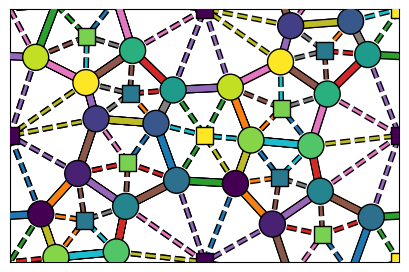

In [66]:
plt.figure(figsize=(20.09/4, 13.142/4))
for i in ce_dict:
    x = 0
    for j in ce_dict[i]:
        
        x1, x2 = _X[j[0]].copy(), _X[j[1]].copy()
        
        d = x2-x1
        
        for _d in range(3):
            
            if d[_d] > 0.5:
                
                x2[_d] -= 1
            
            elif d[_d] < -.5:
                
                x2[_d] += 1
            
        
        
        
        if x == 0:
            
            line = plt.plot([x1[0], x2[0]], [x1[2], x2[2]], lw=4, zorder=5)
            plt.plot([x1[0], x2[0]], [x1[2], x2[2]], lw=6, c='black', zorder=4)

            plt.plot([x1[0], x2[0]], [x1[2]-1, x2[2]-1], c= line[0].get_c(), lw=4, zorder=5)
            plt.plot([x1[0], x2[0]], [x1[2]-1, x2[2]-1], lw=6, c='black', zorder=4)

            plt.plot([x1[0], x2[0]], [x1[2]+1, x2[2]+1], c= line[0].get_c(), lw=4, zorder=5)
            plt.plot([x1[0], x2[0]], [x1[2]+1, x2[2]+1], lw=6, c='black', zorder=4)
        
        plt.plot([x1[0], x2[0]], [x1[2], x2[2]], c= line[0].get_c(),lw=4, zorder=5)
        plt.plot([x1[0], x2[0]], [x1[2], x2[2]], c= 'black',lw=6, zorder=4)
        plt.plot([x1[0], x2[0]], [x1[2]-1, x2[2]-1], c= line[0].get_c(),lw=4, zorder=5)
        plt.plot([x1[0], x2[0]], [x1[2]-1, x2[2]-1], c= 'black',lw=6, zorder=4)
        plt.plot([x1[0], x2[0]], [x1[2]+1, x2[2]+1], c= line[0].get_c(),lw=4, zorder=5)
        plt.plot([x1[0], x2[0]], [x1[2]+1, x2[2]+1], c= 'black',lw=6, zorder=4)
        x+=1
        
        
for i in cp_dict:
    x = 0
    for j in cp_dict[i]:
        
        x1, x2 = _X[j[0]].copy(), X_pore[j[1]].copy()
        
        d = x2-x1
        
        for _d in range(3):
            
            if d[_d] > 0.5:
                
                x2[_d] -= 1
            
            elif d[_d] < -.5:
                
                x2[_d] += 1
            
        
        
        
        if x == 0:
            line = plt.plot([x1[0], x2[0]], [x1[2], x2[2]],lw=2,ls='--', path_effects=[pe.Stroke(linewidth=4, foreground='black'), pe.Normal()])
            plt.plot([x1[0], x2[0]], [x1[2]-1, x2[2]-1],lw=2,ls='--', c= line[0].get_c(), path_effects=[pe.Stroke(linewidth=4, foreground='black'), pe.Normal()])
            plt.plot([x1[0], x2[0]], [x1[2]+1, x2[2]+1],lw=2,ls='--', c= line[0].get_c(), path_effects=[pe.Stroke(linewidth=4, foreground='black'), pe.Normal()])
        
        plt.plot([x1[0], x2[0]], [x1[2], x2[2]], c= line[0].get_c(),lw=2,ls='--', path_effects=[pe.Stroke(linewidth=4, foreground='black'), pe.Normal()])
        plt.plot([x1[0], x2[0]], [x1[2]-1, x2[2]-1], c= line[0].get_c(),lw=2,ls='--', path_effects=[pe.Stroke(linewidth=4, foreground='black'), pe.Normal()])
        plt.plot([x1[0], x2[0]], [x1[2]+1, x2[2]+1], c= line[0].get_c(),lw=2,ls='--', path_effects=[pe.Stroke(linewidth=4, foreground='black'), pe.Normal()])
        #     line = plt.plot([x1[0], x2[0]], [x1[1], x2[1]],lw=2,ls='--', path_effects=[pe.Stroke(linewidth=4, foreground='black')])
        
        # plt.plot([x1[0], x2[0]], [x1[1], x2[1]], c= line[0].get_c(),lw=2,ls='--', path_effects=[pe.Stroke(linewidth=4, foreground='black')])
        x+=1
        

plt.scatter(X_pore[:12,0], X_pore[:12,2], s=150, zorder=10, c=color2, marker='s', edgecolors='black')
plt.scatter(X_pore[:12,0]+1, X_pore[:12,2], s=150, zorder=10, c=color2, marker='s', edgecolors='black')
plt.scatter(X_pore[:12,0], X_pore[:12,2]+1, s=150, zorder=10, c=color2, marker='s', edgecolors='black')
plt.scatter(X_pore[:12,0]+1, X_pore[:12,2]+1, s=150, zorder=10, c=color2, marker='s', edgecolors='black')
plt.xlim(0,1)
plt.ylim(0,1)
plt.xticks([],[])
plt.yticks([],[])
plt.scatter(_X[:,0], _X[:,2], c=color, s=350, zorder=10, edgecolors='black')
# plt.scatter(X[:,0], X[:,1], c='black', s=500, zorder=9)
plt.savefig('figures/weight_sharing_pore_mfi.pdf', bbox_inches='tight', dpi=1200);

In [45]:
X_pore[[3,4]]

array([[0.3028, 0.5   , 0.3919],
       [0.3084, 0.5   , 0.6657]])

In [46]:
X.shape

(96, 3)

In [47]:
A_pore.sum(0)

array([24., 20., 20., 20., 20., 40., 40., 20., 20., 20., 20., 24., 48.,
       48.])

(0.0, 1.0)

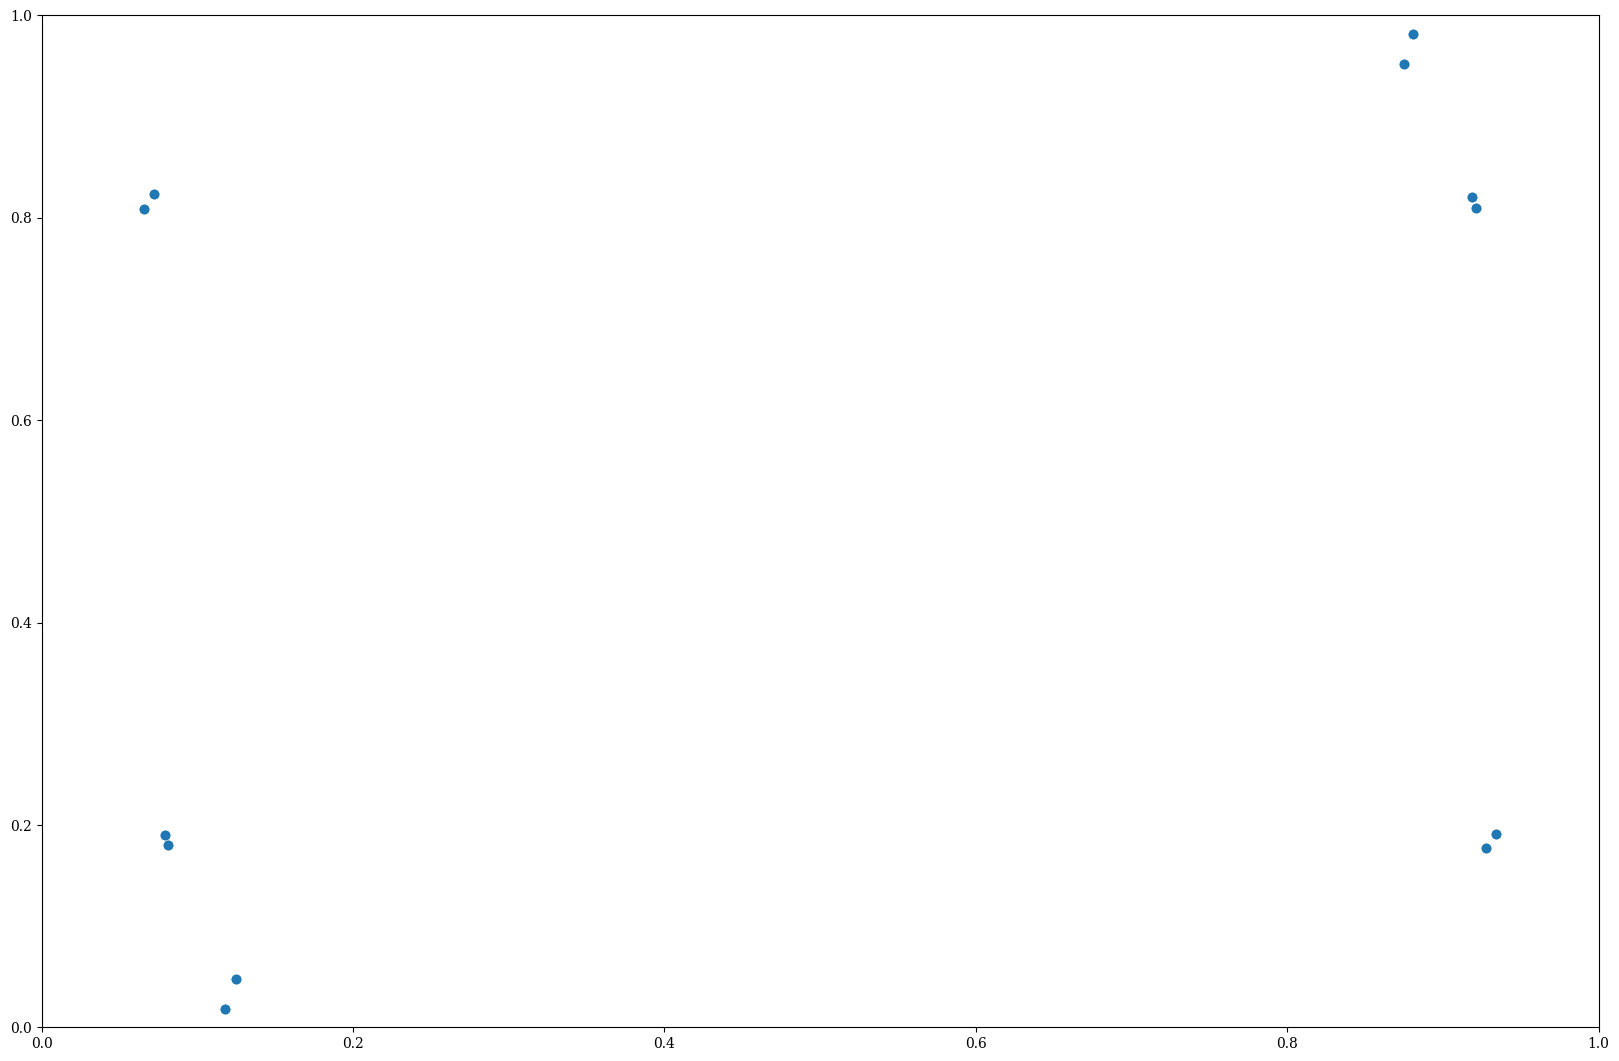

In [48]:
plt.figure(figsize= (l[0],l[2]))
temp_ = X[A_pore[:,11] == 1]
plt.scatter(temp_[:,0],temp_[:,2])
plt.xlim(0,1)
plt.ylim(0,1)


In [49]:
(np.abs(X - [0.875, 0.949, 0.934]) < 0.01).all(1)

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False])

In [50]:
tmp = temp_[temp_[:,1] > 0.75]

In [51]:
tmp

array([[0.118, 0.828, 0.018],
       [0.066, 0.879, 0.809],
       [0.079, 0.929, 0.19 ],
       [0.875, 0.949, 0.952],
       [0.928, 0.964, 0.177],
       [0.919, 0.827, 0.82 ]])

(0.0, 1.0)

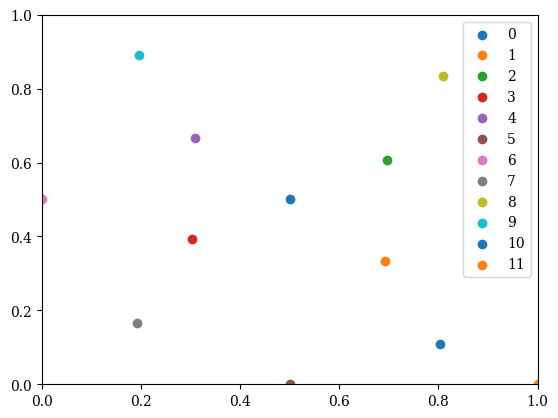

In [52]:
for i in range(len(X_pore)-2):

    plt.scatter(X_pore[i,0],X_pore[i,2], label=i)
plt.legend()
plt.xlim(0,1)
plt.ylim(0,1)

In [53]:
_X = X[X[:,1]>0.75]

In [54]:
np.unique(color, return_counts=True)

(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.]),
 array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int64))

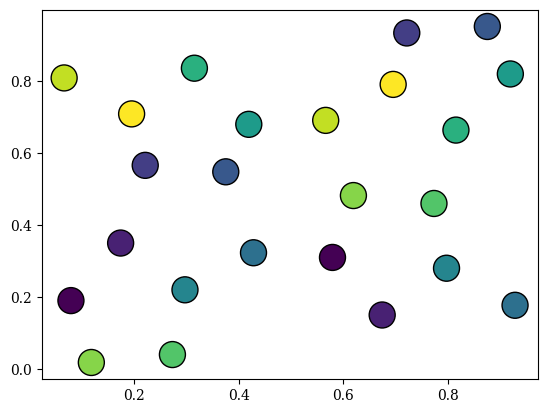

In [55]:
plt.scatter(_X[:,0], _X[:,2], s=350, zorder=10, c=color, edgecolors='black')

In [56]:
X_pore

array([[0.50008333, 0.5       , 0.5       ],
       [0.6917    , 0.5       , 0.3343    ],
       [0.6973    , 0.5       , 0.6081    ],
       [0.3028    , 0.5       , 0.3919    ],
       [0.3084    , 0.5       , 0.6657    ],
       [0.5       , 0.5       , 0.        ],
       [0.        , 0.5       , 0.5       ],
       [0.1916    , 0.5       , 0.1657    ],
       [0.8083    , 0.5       , 0.8343    ],
       [0.1972    , 0.5       , 0.8919    ],
       [0.8027    , 0.5       , 0.1081    ],
       [0.99991667, 0.5       , 0.        ],
       [0.50329167, 0.25      , 0.5       ],
       [0.49670833, 0.75      , 0.5       ]])

In [57]:
np.unique(color, return_counts=True)

(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.]),
 array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int64))